<a href="https://colab.research.google.com/github/mlopes96/analise-exploratoria-com-pandas/blob/main/desafio_dio_transfer_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de Redes Neurais com Transfer Learning

## Desafio DIO Transfer Learning

* **O aprendizado por transferência consiste em pegar recursos aprendidos em um problema e aproveitá-los em um problema novo e semelhante.**
* **Neste exemplo será aproveitado o modelo [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function).**

### Importação das bibliotecas

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.13.0'

### Carregamento das imagens

In [5]:
#Conectando ao google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Realizando a extração do arquivo zip.
path = f'/content/drive/MyDrive/DIO/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

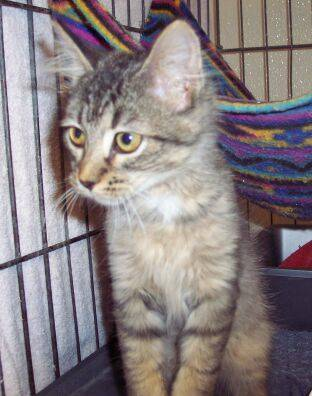

In [11]:
#Visualizando um imagem da pasta de treinamento cat.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.2.jpg')

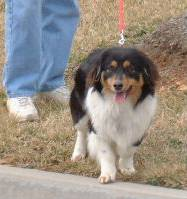

In [12]:
# visualizando uma imagem da pasta de treinamento dog.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.2.jpg')

### Rede neural pré-treinada

In [16]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [18]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [20]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

* **O modelo possui 154 camadas que iremos reaproveitar, para isso foi utilizado o parametro False em layer.trainable para fixar os pesos das camadas.**

### Camada densa personalizada

In [21]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

* **A última camada possui 1280 conexões para realizar a ligação com a nova camada será utilizado apenas metade dessas conexões.**
* **Dropout irá descartar 20% das conexões para próxima camada, isso reduz o overfitting.**
* **Ao final será criado uma camada densa de 2 conexões para classificação (gato,cão).**

In [22]:
(1280 + 2) / 2

641.0

In [23]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

### Construção e treinamento da rede neural

In [24]:
# Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [25]:
# visualizando as informações das camadas.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [26]:
# Adicionamos as 6 camadas finais ao modelo.
len(network.layers)

160

In [28]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                metrics = ['accuracy'])

In [29]:
# Realizando o treinamento com 5 epocas.
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
32/32 [==============================] - 36s 689ms/step - loss: 0.2310 - accuracy: 0.9072
Epoch 2/5
32/32 [==============================] - 21s 644ms/step - loss: 0.1079 - accuracy: 0.9600
Epoch 3/5
32/32 [==============================] - 21s 652ms/step - loss: 0.0947 - accuracy: 0.9610
Epoch 4/5
32/32 [==============================] - 23s 705ms/step - loss: 0.0788 - accuracy: 0.9680
Epoch 5/5
32/32 [==============================] - 21s 652ms/step - loss: 0.0778 - accuracy: 0.9710


### Avaliação da rede neural

In [30]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

1000/1000 [==============================] - 9s 8ms/step - loss: 0.1614 - accuracy: 0.9460


[0.16136643290519714, 0.9459999799728394]

In [31]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

1000/1000 [==============================] - 7s 6ms/step


array([[6.8621941e-02, 9.3137801e-01],
       [9.8507339e-01, 1.4926598e-02],
       [9.9999332e-01, 6.6182401e-06],
       ...,
       [1.2843508e-01, 8.7156498e-01],
       [5.5486490e-03, 9.9445134e-01],
       [6.5412274e-07, 9.9999940e-01]], dtype=float32)

In [32]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [33]:
# classificação real do conjunto de teste.
dataset_teste.classes[:10] # 10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [34]:
# usando a função de acurária do sklearn apenas para comparar se os resultados estão corretos.
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.946

In [35]:
network.evaluate(dataset_teste)

1000/1000 [==============================] - 9s 9ms/step - loss: 0.1614 - accuracy: 0.9460


[0.16136643290519714, 0.9459999799728394]

In [36]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

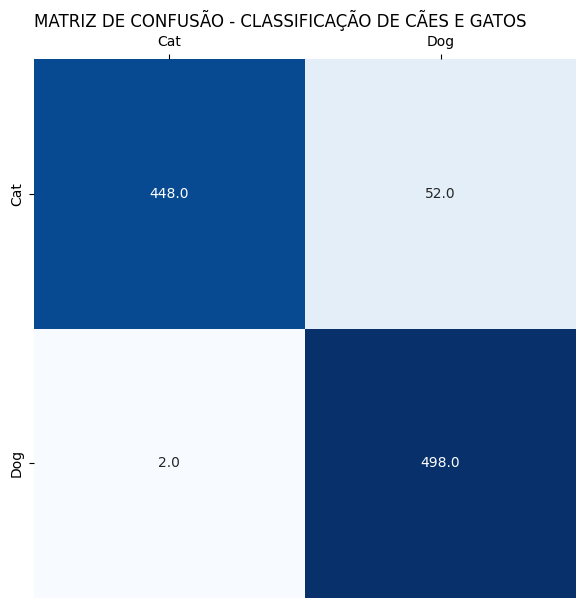

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc='left')
plt.show()

* **Pela matriz podemos ver que o modelo acertou 448 gatos dos 500 e errou 52.**
* **O modelo acertou 498 Cães e classificou 2 de forme equivocada.**


In [39]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       500
           1       0.91      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



* **O modelo teve um resultado bem satisfatório para detectar ambas imagens.**


# Salvar e carregar a rede neural

In [40]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [41]:
# Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-41-a8aee2308f3c>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')


In [42]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint

In [43]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [44]:
# conferindo as informações das camadas.
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

* **Com o modelo salvo podemos criar uma aplicação para consumir o modelo e classificar imagens de cães e gatos.**

# Classificação de uma única imagem

* **Vamos testar em uma única imagem para simular uma aplicação.**

In [45]:
# carregando uma imagem
imagem = cv2.imread('/content/drive/MyDrive/DIO/Labrador.jpg')

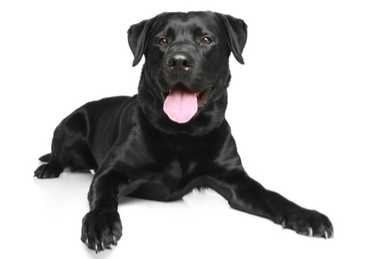

In [46]:
cv2_imshow(imagem)

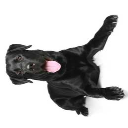

In [47]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem = cv2.resize(imagem, (128, 128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [48]:
# Normalizando a imagem.
imagem = imagem / 255
imagem

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [49]:
# Conferindo o formato
imagem.shape

(128, 128, 3)

In [50]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem = imagem.reshape(1,128,128,3)

In [51]:
# Realizando a previsão.
previsao = network_loaded(imagem)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02456555, 0.9754345 ]], dtype=float32)>

In [52]:
previsao = np.argmax(previsao)
previsao

1

In [53]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [54]:
if previsao == 0:
  print('O modelo identificou que o animal é um: Gato')
else:
  print('O modelo identificou que o animal é um: Cão')

O modelo identificou que o animal é um: Cão
